In [67]:
import os
import pandas as pd
import wget
import sys
import subprocess
from subprocess import call
import matplotlib.pyplot as plt
import seaborn 
import random
%matplotlib inline

import json

import numpy as np

from metamind.api import ClassificationData, ClassificationModel, set_api_key

sys.path.append(os.environ["HOME"])
from ds_config import *

print os.environ["HOME"]
MAIN_PATH = os.environ["HOME"]+"/GLaDOS_Workspace/"
#os.mkdir(MAIN_PATH)
#os.mkdir(MAIN_PATH+"Videos/")
#os.mkdir(MAIN_PATH+"Images/")

seaborn.set_style("white")

/Users/williamspearman


# FFMPEG Scrips

In [9]:
def getVideoInfo(file_name):
    bashCommand = "ffprobe -show_streams " + file_name
    process = subprocess.Popen(bashCommand.split(" "), stdout=subprocess.PIPE)
    output = process.communicate()[0].split("\n")
    ret_dict = { }
    for x in output:
        if "=" in x:
            key_vals = x.split("=")
            ret_dict[key_vals[0]] = key_vals[1]
    #print ret_dict
    return ret_dict

def getRandInt(int1, int2):
    if int1[0]>=int1[1]:
        return np.random.randint(int2[0],int2[1])
    elif int2[0]>=int2[1]:
        return np.random.randint(int1[0],int1[1])
    
    if np.random.random() > 0.5:
        return np.random.randint(int1[0],int1[1])
    else:
        return np.random.randint(int2[0],int2[1])

    

def getClipTriplets(file_name, snap_time, pm_secs=1.):
    ret_val = { }
    info_dict = getVideoInfo(file_name)
    required_vals = { "duration", "nb_frames", "avg_frame_rate", "sample_aspect_ratio" }
    if len(required_vals.intersection(set(info_dict.keys())))!=len(required_vals):
        return None
    frame_rate = 0.
    try:
        frame_rate = float(info_dict["avg_frame_rate"].split("/")[0])/float(info_dict["avg_frame_rate"].split("/")[1])
    except:
        return None
    num_frames = float(info_dict["nb_frames"])
    duration = float(info_dict["duration"])

    if int(num_frames/frame_rate-duration)!= 0:
        return None
    
    pm_frames = pm_secs * frame_rate
    snap_frame = snap_time * frame_rate
    
    snap_frame_low = 0.
    snap_frame_med = snap_frame_low+1.*pm_frames
    snap_frame_high = snap_frame_low+2.*pm_frames
    while snap_frame_high<=num_frames:
        ret_val["TIME_%i_%i" % (snap_frame_low, snap_frame_high)] = \
        [ snap_frame_low/frame_rate, snap_frame_med/frame_rate, snap_frame_high/frame_rate ]
        snap_frame_low += pm_frames
        snap_frame_med += pm_frames
        snap_frame_high += pm_frames
    
    
    return ret_val
    
def downloadUrl(url):
    base_name = ""
    try:
        base_name = url.split("/")[-1]
    except:
        return ""
    
    output_name = MAIN_PATH + "Videos/" + base_name
    if os.path.isfile(output_name)==False:
        wget.download(url, MAIN_PATH+"Videos/")
    
    if os.path.isfile(output_name)==True:
        return output_name
    else:
        return ""


def getGetSignalBkgTriplets(file_name, snap_time, pm_secs=1.):
    ret_val = { }
    info_dict = getVideoInfo(file_name)
    required_vals = { "duration", "nb_frames", "avg_frame_rate", "sample_aspect_ratio" }
    if len(required_vals.intersection(set(info_dict.keys())))!=len(required_vals):
        return None
    frame_rate = 0.
    try:
        frame_rate = float(info_dict["avg_frame_rate"].split("/")[0])/float(info_dict["avg_frame_rate"].split("/")[1])
    except:
        return None
    num_frames = float(info_dict["nb_frames"])
    duration = float(info_dict["duration"])

    if int(num_frames/frame_rate-duration)!= 0:
        return None
    
    pm_frames = pm_secs * frame_rate
    snap_frame = snap_time * frame_rate
    
    snap_frame_low = snap_frame-pm_frames
    snap_frame_high = snap_frame+pm_frames
    if snap_frame_low<0:
        return None
    if snap_frame_high>num_frames:
        return None
    
    int1 = [ pm_frames, max(0,snap_frame_low-pm_frames) ]
    int2 = [ min(pm_frames+snap_frame_high, num_frames), num_frames-pm_frames ]
    bkg_frame = getRandInt(int1, int2)
    
    ret_val["SNAP"] = [ snap_frame_low/frame_rate, snap_frame/frame_rate, snap_frame_high/frame_rate ]
    ret_val["NOT_SNAP"] = [ (bkg_frame-pm_frames)/frame_rate, bkg_frame/frame_rate, (bkg_frame+pm_frames)/frame_rate ]
    
    return ret_val
    
def downloadUrl(url):
    base_name = ""
    try:
        base_name = url.split("/")[-1]
    except:
        return ""
    
    output_name = MAIN_PATH + "Videos/" + base_name
    if os.path.isfile(output_name)==False:
        wget.download(url, MAIN_PATH+"Videos/")
    
    if os.path.isfile(output_name)==True:
        return output_name
    else:
        return ""



def makeImageMontage(url, snap_time, time_offset=0.5, triplets=True):
    ret_val = [ ]
    video_path = downloadUrl(url)
    #print "BLah %f" % 0.2
    base_name = ""
    try:
        base_name = video_path.split("/")[-1].split(".")[0]
    except:
        print "Failed splitting: %s" % video_path
        return None
    input_times = None
    if triplets:
        input_times = getGetSignalBkgTriplets(video_path, snap_time, time_offset)
    else:
        input_times = getClipTriplets(video_path, snap_time, time_offset)
    if input_times==None:
        return ret_val
    #resolution = resolution.replace(":", "x")
    #name1 = "blah"
    #name2 = "blah"
    ffmpeg_cmds = { }
    file_names = { }
    for mykey in input_times.keys():
        output_name = MAIN_PATH + "Images/" + base_name
        ffmpeg_cmds[mykey] = [ ]
        file_names[mykey] = [ ]
        for x, i in zip(input_times[mykey], range(0,len(input_times[mykey]))):
            file_name = "%s_%i_%s.jpg" % (output_name, i, mykey)
            file_names[mykey].append(file_name)
            ffmpeg_cmds[mykey].append("ffmpeg -ss %f -i %s -vframes 1 %s 2> /dev/null" % (x, video_path, file_name))
        #montage_cmd = "montage -tile 1x3 -geometry 512x256+0+0 "
        montage_cmd = "montage -tile 1x3 -geometry 512x+0+0 "
        for thecmd, fname in zip(ffmpeg_cmds[mykey], file_names[mykey]):
            call(thecmd, shell=True)
            montage_cmd = montage_cmd+fname+" "
        montage_name = "%s_%i_%s_MONTAGE.jpg" % (output_name, int(1000*input_times[mykey][1]), mykey)
        montage_cmd = montage_cmd + " " + montage_name
        call(montage_cmd,shell=True)
        for fname in file_names[mykey]:
            try:
                os.remove(fname)
            except:
                print "Couldn't remove %s" % fname
        ret_val.append((montage_name, mykey))
        
        
        
            
    return ret_val


In [10]:
getClipTriplets("/Users/williamspearman/GLaDOS_Workspace/Videos/lelyp36kuaykgm1j-3000_1100.mp4", 8.809, 0.5)

{'TIME_0_30': [0.0, 0.5, 1.0],
 'TIME_105_135': [3.5, 4.0, 4.5],
 'TIME_120_150': [4.0, 4.5, 5.0],
 'TIME_135_165': [4.5, 5.0, 5.5],
 'TIME_150_180': [5.0, 5.5, 6.0],
 'TIME_15_45': [0.5, 1.0, 1.5],
 'TIME_165_195': [5.5, 6.0, 6.5],
 'TIME_180_210': [6.0, 6.5, 7.0],
 'TIME_195_225': [6.5, 7.0, 7.5],
 'TIME_210_240': [7.0, 7.5, 8.0],
 'TIME_225_255': [7.5, 8.0, 8.5],
 'TIME_240_270': [8.0, 8.5, 9.0],
 'TIME_255_285': [8.5, 9.0, 9.5],
 'TIME_270_300': [9.0, 9.5, 10.0],
 'TIME_285_315': [9.5, 10.0, 10.5],
 'TIME_300_330': [10.0, 10.5, 11.0],
 'TIME_30_60': [1.0, 1.5, 2.0],
 'TIME_315_345': [10.5, 11.0, 11.5],
 'TIME_330_360': [11.0, 11.5, 12.0],
 'TIME_345_375': [11.5, 12.0, 12.5],
 'TIME_360_390': [12.0, 12.5, 13.0],
 'TIME_375_405': [12.5, 13.0, 13.5],
 'TIME_390_420': [13.0, 13.5, 14.0],
 'TIME_405_435': [13.5, 14.0, 14.5],
 'TIME_420_450': [14.0, 14.5, 15.0],
 'TIME_435_465': [14.5, 15.0, 15.5],
 'TIME_450_480': [15.0, 15.5, 16.0],
 'TIME_45_75': [1.5, 2.0, 2.5],
 'TIME_465_495': [15.

In [11]:
print makeImageMontage("http://vf.hudl.com/9n6/81k/bab387d7-c875-4df6-89f7-3a0c910deb6a/lelyp36kuaykgm1j-3000_1100.mp4", 8.809, 0.5, False)

Couldn't remove /Users/williamspearman/GLaDOS_Workspace/Images/lelyp36kuaykgm1j-3000_1100_2_TIME_645_675.jpg
[('/Users/williamspearman/GLaDOS_Workspace/Images/lelyp36kuaykgm1j-3000_1100_15500_TIME_450_480_MONTAGE.jpg', 'TIME_450_480'), ('/Users/williamspearman/GLaDOS_Workspace/Images/lelyp36kuaykgm1j-3000_1100_2000_TIME_45_75_MONTAGE.jpg', 'TIME_45_75'), ('/Users/williamspearman/GLaDOS_Workspace/Images/lelyp36kuaykgm1j-3000_1100_10500_TIME_300_330_MONTAGE.jpg', 'TIME_300_330'), ('/Users/williamspearman/GLaDOS_Workspace/Images/lelyp36kuaykgm1j-3000_1100_14500_TIME_420_450_MONTAGE.jpg', 'TIME_420_450'), ('/Users/williamspearman/GLaDOS_Workspace/Images/lelyp36kuaykgm1j-3000_1100_11500_TIME_330_360_MONTAGE.jpg', 'TIME_330_360'), ('/Users/williamspearman/GLaDOS_Workspace/Images/lelyp36kuaykgm1j-3000_1100_17000_TIME_495_525_MONTAGE.jpg', 'TIME_495_525'), ('/Users/williamspearman/GLaDOS_Workspace/Images/lelyp36kuaykgm1j-3000_1100_19000_TIME_555_585_MONTAGE.jpg', 'TIME_555_585'), ('/Users/will

In [30]:
snapRDD = sc.textFile("s3n://hudl-hadoop/GLaDOS/snap_detect_data/").map(json.loads)

In [31]:
snapRDD_size = snapRDD.count()
trainNum = 500.
testNum = 20.

snapRDD_train = snapRDD.sample(False, trainNum/snapRDD_size).cache()
snapRDD_test = snapRDD.sample(False, testNum/snapRDD_size).cache()
print snapRDD_train.count()
print snapRDD_test.count()

502
15


In [32]:
training_inputRDD = snapRDD_train\
    .flatMap(lambda x: makeImageMontage(x["video"]["urls"][-1],x["video"]["snap time"]))
training_inputs = training_inputRDD.collect()

In [33]:
test_inputRDD = snapRDD_test\
    .flatMap(lambda x: makeImageMontage(x["video"]["urls"][-1],x["video"]["snap time"]))
test_inputs = training_inputRDD.collect()

In [13]:
set_api_key(metamind_api_key)

Hello, William Spearman


In [35]:
training_data = ClassificationData(private=True, data_type="image", name="snap_detect")

You are creating dataset 'snap_detect', with id: 152216


In [ ]:
training_data.add_samples(training_inputs, input_type="files")

Starting data upload...
Finished uploading 150 of 890 samples...
Finished uploading 300 of 890 samples...
Finished uploading 450 of 890 samples...
Finished uploading 600 of 890 samples...
Finished uploading 750 of 890 samples...
Finished uploading 890 of 890 samples...


In [ ]:
classifier = ClassificationModel(private=True, name="snap_detect")


Your MetaMind image model is now training on the server!
Your model is in the training queue for free users!
Your model is in the training queue for free users!
Your model is in the training queue for free users!
Your model is in the training queue for free users!
Your model is in the training queue for free users!
Your model is in the training queue for free users!
Your model is in the training queue for free users!
Your model is in the training queue for free users!
Your model is in the training queue for free users!
Your model is in the training queue for free users!
Your model is in the training queue for free users!

In [5]:
classifier = ClassificationModel(id=18409)
training_data = ClassificationData(id=152216)
classifier.fit_async(training_data)

You are fetching dataset 'snap_detect', with id: 152216
Your MetaMind image model is now training on the server!


In [37]:
classifier.status()

u'done'

0.0598103523254


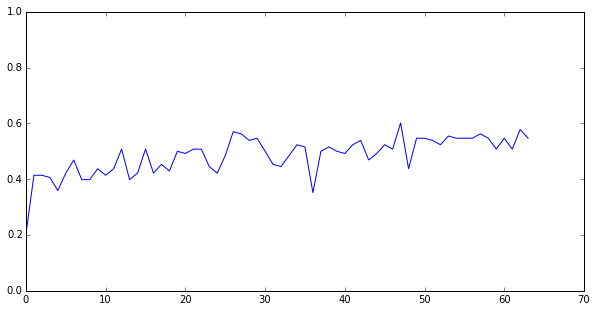

In [39]:
plt.figure(figsize=(10, 5))
print classifier.stats()["time_left"] / 60.

plt.plot(classifier.stats()["training_stats"]["train_accuracy"])
plt.ylim([0, 1])
plt.show() 


In [12]:
singleClips = makeImageMontage("http://vf.hudl.com/9n6/81k/bab387d7-c875-4df6-89f7-3a0c910deb6a/lelyp36kuaykgm1j-3000_1100.mp4", 8.809, 0.5, False)

Couldn't remove /Users/williamspearman/GLaDOS_Workspace/Images/lelyp36kuaykgm1j-3000_1100_2_TIME_645_675.jpg


In [14]:
singleClips

[('/Users/williamspearman/GLaDOS_Workspace/Images/lelyp36kuaykgm1j-3000_1100_15500_TIME_450_480_MONTAGE.jpg',
  'TIME_450_480'),
 ('/Users/williamspearman/GLaDOS_Workspace/Images/lelyp36kuaykgm1j-3000_1100_2000_TIME_45_75_MONTAGE.jpg',
  'TIME_45_75'),
 ('/Users/williamspearman/GLaDOS_Workspace/Images/lelyp36kuaykgm1j-3000_1100_10500_TIME_300_330_MONTAGE.jpg',
  'TIME_300_330'),
 ('/Users/williamspearman/GLaDOS_Workspace/Images/lelyp36kuaykgm1j-3000_1100_14500_TIME_420_450_MONTAGE.jpg',
  'TIME_420_450'),
 ('/Users/williamspearman/GLaDOS_Workspace/Images/lelyp36kuaykgm1j-3000_1100_11500_TIME_330_360_MONTAGE.jpg',
  'TIME_330_360'),
 ('/Users/williamspearman/GLaDOS_Workspace/Images/lelyp36kuaykgm1j-3000_1100_17000_TIME_495_525_MONTAGE.jpg',
  'TIME_495_525'),
 ('/Users/williamspearman/GLaDOS_Workspace/Images/lelyp36kuaykgm1j-3000_1100_19000_TIME_555_585_MONTAGE.jpg',
  'TIME_555_585'),
 ('/Users/williamspearman/GLaDOS_Workspace/Images/lelyp36kuaykgm1j-3000_1100_18500_TIME_540_570_MONTAG

In [16]:
classifier = ClassificationModel(id=18410)

print classifier.predict(singleClips[-1][0], input_type="files")


[{u'user_value': u'/Users/williamspearman/GLaDOS_Workspace/Images/lelyp36kuaykgm1j-3000_1100_12000_TIME_345_375_MONTAGE.jpg', u'probability': 0.5627609491348267, u'label': u'NOT_SNAP'}]


In [18]:


predictions = [ ]

for x in singleClips:
    time = float(x[1].split("_")[-1])
    result = classifier.predict(x[0], input_type="files")
    prediction = result[0]['label']
    prob_snap=0.
    if prediction=="SNAP":
        prob_snap=result[0]["probability"]
    else:
        prob_snap=1-result[0]["probability"]
    predictions.append( (time, prob_snap) )

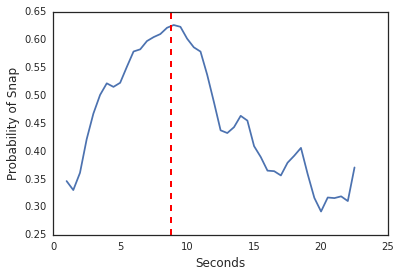

In [68]:
predictions = sorted(predictions)
np_arr = np.array(predictions)

x = [ ]

for tmp in np_arr[:,0]:
    x.append(tmp/30.)
y = np_arr[:,1]
#print x
#print y

x2 = [ 8.809 ]
y2 = [ 1. ]

plt.plot(x,y)
plt.axvline(8.809, color='r', linestyle='dashed', linewidth=2) 
plt.xlabel('Seconds', fontsize=12)
plt.ylabel('Probability of Snap', fontsize=12)
#plt.show()
plt.savefig("SnapProbability.png")

In [71]:
#singleClips = makeImageMontage("http://vf.hudl.com/9n6/81k/bab387d7-c875-4df6-89f7-3a0c910deb6a/lelyp36kuaykgm1j-3000_1100.mp4", 8.809, 0.5, False)

def DetectSnap(url, snap_time, time_offset=1.):
    base_name = url.split("/")[-1].split(".mp4")[0]
    singleClips = makeImageMontage(url, snap_time, time_offset, False)
    classifier = ClassificationModel(id=18410)

    predictions = [ ]

    length = len(singleClips)
    if length<=0:
        return
    for x, i in zip(singleClips, range(0,length)):
        print "On %i of %i" % (i, length)
        time = float(x[1].split("_")[-1])
        result = classifier.predict(x[0], input_type="files")
        prediction = result[0]['label']
        prob_snap=0.
        if prediction=="SNAP":
            prob_snap=result[0]["probability"]
        else:
            prob_snap=1-result[0]["probability"]
        print "Probability %f for time %f" % (prob_snap, time)
        predictions.append( (time, prob_snap) )
        
    predictions = sorted(predictions)
    np_arr = np.array(predictions)

    x = [ ]

    for tmp in np_arr[:,0]:
        x.append(tmp/30.)
    y = np_arr[:,1]
    #print x
    #print y

    #x2 = [ 8.809 ]
    #y2 = [ 1. ]

    plt.plot(x,y)
    plt.axvline(snap_time, color='r', linestyle='dashed', linewidth=2) 
    plt.xlabel('Seconds', fontsize=12)
    plt.ylabel('Probability of Snap', fontsize=12)
    #plt.show()
    plt.savefig("SnapProbability_%s.png" % base_name)
    plt.show()
    return np_arr

In [75]:
formationRDD = sc.textFile("s3n://hudl-hadoop/GLaDOS/formation_data/").map(json.loads)

In [ ]:
files_to_run = formationRDD.map(lambda x: (x["video"]["snap time"], x["video"]["urls"][0])).takeSample(False,10)
random.shuffle(files_to_run)

Couldn't remove /Users/williamspearman/GLaDOS_Workspace/Images/xjreozdhtz0mhi7y-1100_2_TIME_360_390.jpg
On 0 of 25
Probability 0.446290 for time 75.000000
On 1 of 25
Probability 0.202164 for time 330.000000
On 2 of 25
Probability 0.195017 for time 360.000000
On 3 of 25
Probability 0.389432 for time 120.000000
On 4 of 25
Probability 0.294832 for time 195.000000
On 5 of 25
Probability 0.425300 for time 105.000000
On 6 of 25
Probability 0.352428 for time 165.000000
On 7 of 25
Probability 0.430480 for time 90.000000
On 8 of 25
Probability 0.460379 for time 60.000000
On 9 of 25
Probability 0.297771 for time 180.000000
On 10 of 25
Probability 0.509773 for time 45.000000
On 11 of 25
Probability 0.378761 for time 135.000000
On 12 of 25
Probability 0.281604 for time 270.000000
On 13 of 25
Probability 0.232777 for time 300.000000
On 14 of 25
Probability 0.231947 for time 315.000000
On 15 of 25
Probability 0.196892 for time 345.000000
On 16 of 25
Probability 0.278345 for time 240.000000
On 17 of 

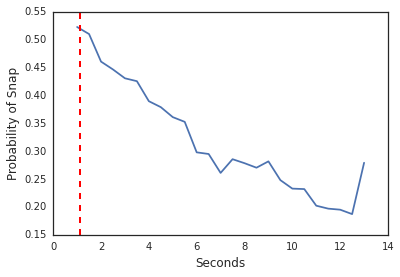

Couldn't remove /Users/williamspearman/GLaDOS_Workspace/Images/82n5vsqx4yfv4ndo-3000_2_TIME_285_315.jpg
On 0 of 20
Probability 0.425870 for time 45.000000
On 1 of 20
Probability 0.519082 for time 255.000000

In [ ]:
data = [ ]

for x in files_to_run:
    data.append(DetectSnap(x[1],x[0],0.5))

In [88]:
preds = classifier.predict(fg_test_set, input_type="files")

/home/ubuntu/anaconda/lib/python2.7/site-packages/requests/packages/urllib3/util/ssl_.py:79: InsecurePlatformWarning: A true SSLContext object is not available. This prevents urllib3 from configuring SSL appropriately and may cause certain SSL connections to fail. For more information, see https://urllib3.readthedocs.org/en/latest/security.html#insecureplatformwarning.
  InsecurePlatformWarning
/home/ubuntu/anaconda/lib/python2.7/site-packages/requests/packages/urllib3/util/ssl_.py:79: InsecurePlatformWarning: A true SSLContext object is not available. This prevents urllib3 from configuring SSL appropriately and may cause certain SSL connections to fail. For more information, see https://urllib3.readthedocs.org/en/latest/security.html#insecureplatformwarning.
  InsecurePlatformWarning
Traceback (most recent call last):
  File "/home/ubuntu/anaconda/lib/python2.7/site-packages/metamind/api/utils.py", line 34, in make_request
    return validate_result(response)
  File "/home/ubuntu/anac

In [94]:
preds = pd.DataFrame([
    classifier.predict(fg, input_type="files") for fg in fg_test_set
])

/home/ubuntu/anaconda/lib/python2.7/site-packages/requests/packages/urllib3/util/ssl_.py:79: InsecurePlatformWarning: A true SSLContext object is not available. This prevents urllib3 from configuring SSL appropriately and may cause certain SSL connections to fail. For more information, see https://urllib3.readthedocs.org/en/latest/security.html#insecureplatformwarning.
  InsecurePlatformWarning
/home/ubuntu/anaconda/lib/python2.7/site-packages/requests/packages/urllib3/util/ssl_.py:79: InsecurePlatformWarning: A true SSLContext object is not available. This prevents urllib3 from configuring SSL appropriately and may cause certain SSL connections to fail. For more information, see https://urllib3.readthedocs.org/en/latest/security.html#insecureplatformwarning.
  InsecurePlatformWarning
/home/ubuntu/anaconda/lib/python2.7/site-packages/requests/packages/urllib3/util/ssl_.py:79: InsecurePlatformWarning: A true SSLContext object is not available. This prevents urllib3 from configuring SSL 